In [1]:
import glob
import os

import cartopy.crs as ccrs
from datetime import date
import dask.array as da
from dask.distributed import Client
from dask.distributed import LocalCluster
import matplotlib.pyplot as plt
import numpy as np

import basd
import xarray as xr

# Define Paths

In [2]:
data_path = '/Users/prim232/data/'
gswp3_data_path = os.path.join(data_path, 'gswp3')
mri_data_path = os.path.join(data_path, 'MRI-ESM2-0')
plot_path = '/Users/prim232/OneDrive - PNNL/Documents/BASD/plots'

In [3]:
pr_obs_hist_pattern = 'pr_gswp3_*.nc4'
pr_sim_hist_pattern = 'pr_day_MRI-ESM2-0_historical_*.nc'
pr_sim_fut_pattern = 'pr_day_MRI-ESM2-0_ssp245_*.nc'

# tasskew

In [3]:
obs_fine = xr.open_mfdataset(os.path.join(mri_data_path, 'tasskew_obs_hist.nc'), chunks={'time': 100}).persist()
sim_coarse = xr.open_mfdataset(os.path.join(mri_data_path, 'tasskew_sim_coarse.nc'), chunks={'time': 100}).persist()

In [4]:
params = basd.Parameters(lower_bound=0,
                         lower_threshold=0.0001,
                         upper_bound=1,
                         upper_threshold=0.9999,
                         trend_preservation='bounded',
                         if_all_invalid_use=0,
                         n_iterations=5
                         )

In [ ]:
with LocalCluster(processes=True, threads_per_worker=1) as cluster, Client(cluster) as client:
    print(client.dashboard_link)
    sd = basd.Downscaler(obs_fine, sim_coarse, 'tasskew', params)
    sd.downscale(lat_chunk_size=5, lon_chunk_size=5, file=os.path.join(data_path, 'tasskew_basd.nc'))

http://127.0.0.1:8787/status


2023-01-19 14:20:06,587 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:62364 -> tcp://127.0.0.1:62362
Traceback (most recent call last):
  File "/Users/prim232/opt/miniconda3/envs/xesmf_env/lib/python3.9/site-packages/tornado/iostream.py", line 973, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/prim232/opt/miniconda3/envs/xesmf_env/lib/python3.9/site-packages/tornado/iostream.py", line 1146, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/prim232/opt/miniconda3/envs/xesmf_env/lib/python3.9/site-packages/distributed/worker.py", line 1757, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/prim232/opt/miniconda3/envs/xesmf_env/lib/python3.9/site-packages/distributed/comm/tcp.py", line 241, in read

# Read in Data
Here we read in `xarray.DataSet`s into lists for each year chunk

In [4]:
pr_obs_hist = xr.open_mfdataset(os.path.join(gswp3_data_path, pr_obs_hist_pattern), chunks={'time': 100})
pr_sim_hist = xr.open_mfdataset(os.path.join(mri_data_path, pr_sim_hist_pattern), chunks={'time': 100})
pr_sim_fut = xr.open_mfdataset(os.path.join(mri_data_path, pr_sim_fut_pattern), chunks={'time': 100})

In [ ]:
# Using historical years 1975-2010
pr_obs_hist = pr_obs_hist.where(np.logical_and(1975 <= pr_obs_hist['time.year'],
                                               1975 <= pr_obs_hist['time.year']),
                                drop=True)
pr_sim_hist = pr_sim_hist.where(np.logical_and(1975 <= pr_sim_hist['time.year'],
                                               1975 <= pr_sim_hist['time.year']),
                                drop=True)
pr_obs_hist = basd.project_onto(pr_obs_hist, pr_sim_hist, 'pr')

In [ ]:
pr_obs_hist = pr_obs_hist[dict(lat=np.arange(0,20), lon=np.arange(0,20))]
pr_sim_hist = pr_sim_hist[dict(lat=np.arange(0,20), lon=np.arange(0,20))]
pr_sim_fut = pr_sim_fut[dict(lat=np.arange(0,20), lon=np.arange(0,20))]

# Create Parameters and Adjustment Objects

In [4]:
pr_params = basd.Parameters(lower_bound=0,
                            lower_threshold=0.0000011574,
                            trend_preservation='mixed',
                            distribution='gamma',
                            if_all_invalid_use=0,
                            n_iterations=5)

In [ ]:
with LocalCluster(processes=True, threads_per_worker=1) as cluster, Client(cluster) as client:
    print(client.dashboard_link)
    ba = basd.Adjustment(pr_obs_hist, pr_sim_hist, pr_sim_fut,
                     'pr', pr_params, remap_grid=True )
    ba.adjust_bias(lat_chunk_size=5, lon_chunk_size=5, path=os.path.join(data_path, 'bias-adjusted'))

In [ ]:
tas_path = os.path.join(data_path, 'bias-adjusted', 'MRI-ESM2-gswp3', 'tas')

In [ ]:
tas_fut_ba = xr.open_dataset(os.path.join(tas_path, 'tas_2015-2100.nc')).transpose('time', 'lat', 'lon',...)

In [ ]:
ax = plt.axes(projection=ccrs.Orthographic(-80,35))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
tas_fut_ba['tas'][dict(time=0)].plot(ax=ax, transform=ccrs.PlateCarree(),
                                     cmap='coolwarm',
                                     cbar_kwargs={'label': '',
                                                  'location': 'bottom',
                                                  'aspect': 50,
                                                  'pad': 0.05})
ax.set_title('Near Surface Air Temperature (K), 01-01-2015')
ax.coastlines(linewidth=0.5)
plt.savefig(os.path.join(plot_path, 'ortho-tas_MRI-ESM2-0_gswp3_01-01-2015.pdf'))
plt.savefig(os.path.join(plot_path, 'ortho-tas_MRI-ESM2-0_gswp3_01-01-2015.png'),
            dpi=300, transparent=True)

In [ ]:
output_one_loc = ba.adjust_bias_one_location(dict(lat=25, lon=80))

In [ ]:
output_one_loc.plot_ecdf(log_x=True)

# Downscaling

#### Defining more paths

In [5]:
# Paths to the bias adjusted and (separately) downscaled output
ba_path = os.path.join(data_path, 'bias-adjusted', 'MRI-ESM2-gswp3')
basd_path = os.path.join(data_path, 'downscaled', 'MRI-ESM2-gswp3')

In [6]:
# File name patterns
pr_obs_fine_pattern = 'pr_gswp3_*.nc4'
pr_sim_coarse_pattern = 'pr_2015-2100.nc'

#### Loading the required datasets

In [7]:
pr_obs_fine = xr.open_mfdataset(os.path.join(gswp3_data_path, pr_obs_fine_pattern), chunks={'time': 100})
pr_sim_coarse = xr.open_mfdataset(os.path.join(ba_path, pr_sim_coarse_pattern), chunks={'time': 100})

In [8]:
pr_sim_coarse = basd.reproject_for_integer_factors(pr_obs_fine, pr_sim_coarse, 'pr')

In [9]:
pr_sim_fine = basd.project_onto(pr_sim_coarse, pr_obs_fine, 'pr')

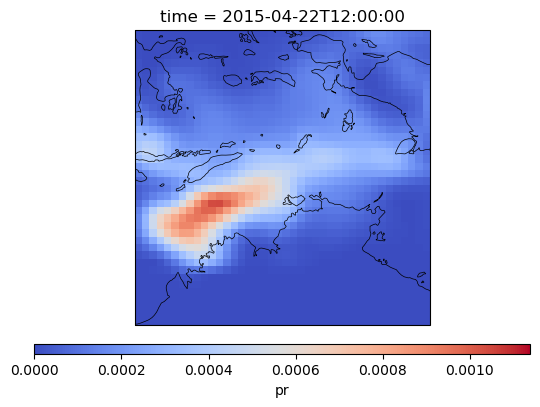

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([120, 140, -20, 0])
pr_sim_fine['pr'][dict(time=111)].plot(ax=ax, transform=ccrs.PlateCarree(),
#pr_sim_coarse['pr'][dict(lat=np.arange(90, 110), lon=np.arange(300,320), time=111)].plot(ax=ax, transform=ccrs.PlateCarree(),
                                   cmap='coolwarm',
                                   cbar_kwargs={'location': 'bottom',
                                                'aspect': 50,
                                                'pad': 0.05})
ax.coastlines(linewidth=0.5)

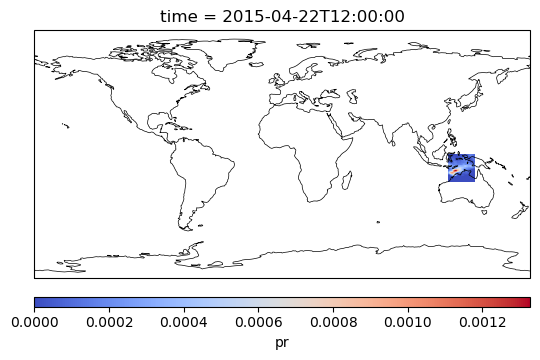

In [63]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
pr_sim_fine['pr'][dict(lat=np.arange(180, 220), lon=np.arange(600,640), time=111)].plot(ax=ax, transform=ccrs.PlateCarree(),
                                   cmap='coolwarm',
                                   cbar_kwargs={'location': 'bottom',
                                                'aspect': 50,
                                                'pad': 0.05})
ax.coastlines(linewidth=0.5)
#plt.savefig(os.path.join(plot_path, 'pr_MRI-ESM2-0_bilinear.pdf'))

In [9]:
pr_obs_fine = pr_obs_fine[dict(lat=np.arange(180, 220), lon=np.arange(600,640))]
pr_sim_coarse = pr_sim_coarse[dict(lat=np.arange(90, 110), lon=np.arange(300,320))]

#### Running the downscaling routine

First, we fire up processes as before using `LocalCluster` and `Client` from `dask.distributed`. With these running, our function, `downscale`, which takes advantage of Dask, will automatically deploy tasks to the workers created. To run the downscaling routine, we first set it up by creating a `Downscaler` object with all of our needed data, and then call `downscale` on that object. We also pass a file path to save out output to.

In [10]:
with LocalCluster(processes=True, threads_per_worker=1) as cluster, Client(cluster) as client:
    print(client.dashboard_link)
    sd = basd.Downscaler(pr_obs_fine, pr_sim_coarse, 'pr', pr_params)
    sd.downscale(lat_chunk_size=5, lon_chunk_size=5, file=os.path.join(basd_path, 'pr_2015-2100.nc'))

/Users/prim232/opt/miniconda3/envs/xesmf_env/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56017 instead
  warnings.warn(


http://127.0.0.1:56017/status
Initial Coarse Value: 4.063652886543423e-05
Initial Agg fine value: 9.567340326173366e-05
Initial Coarse Value Scaled: 8.127305045491084e-05
Final Agg fine value: 8.155693942917031e-05
Sum weights: [0.50021003 0.50021003 0.49978988 0.49978988]
Sum weights shape: (4,)
obs fine shape: (930, 4)
Sim fine shape: (2666, 4)
Sim coarse shape: (2666,)
Initial Coarse Value: 0.0001471126888645813
Initial Agg fine value: 0.00031487511944022165
Initial Coarse Value Scaled: 0.0002942253486253321
Final Agg fine value: 0.0002891006390688649
Sum weights: [0.50021003 0.50021003 0.49978988 0.49978988]
Sum weights shape: (4,)
obs fine shape: (847, 4)
Sim fine shape: (2429, 4)
Sim coarse shape: (2429,)
Initial Coarse Value: 6.241830851649866e-05
Initial Agg fine value: 0.0001334705357415454
Initial Coarse Value Scaled: 0.00012483660248108208
Final Agg fine value: 0.00012588102105042616
Sum weights: [0.50021003 0.50021003 0.49978988 0.49978988]
Sum weights shape: (4,)
obs fine 

In [11]:
pr_sim_fine = xr.open_dataset(os.path.join(basd_path, 'pr_2015-2100.nc'))

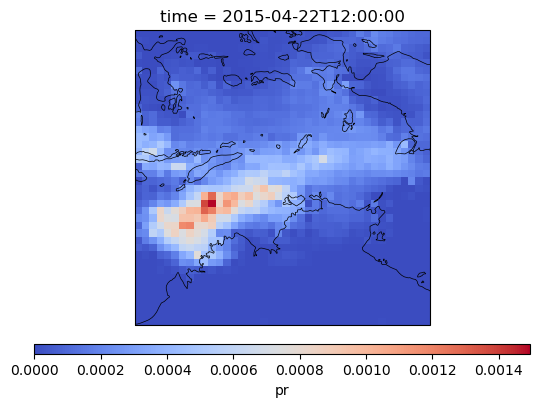

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([120, 140, -20, 0])
pr_sim_fine['pr'][dict(time=111)].plot(ax=ax, transform=ccrs.PlateCarree(),
                                   cmap='coolwarm',
                                   cbar_kwargs={'location': 'bottom',
                                                'aspect': 50,
                                                'pad': 0.05})
ax.coastlines(linewidth=0.5)
plt.savefig(os.path.join(plot_path, 'pr_MRI-ESM2-0_small_1.pdf'))

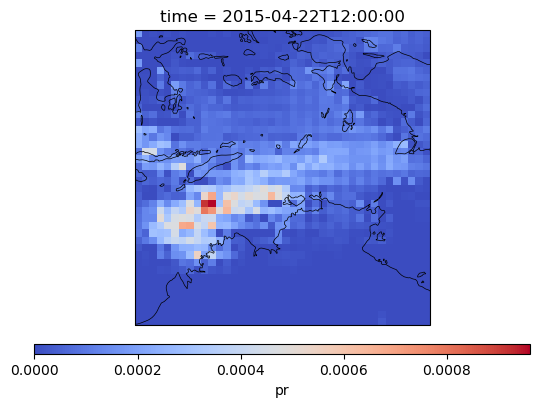

In [86]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([120, 140, -20, 0])
pr_sim_fine['pr'][dict(time=111)].plot(ax=ax, transform=ccrs.PlateCarree(),
                                   cmap='coolwarm',
                                   cbar_kwargs={'location': 'bottom',
                                                'aspect': 50,
                                                'pad': 0.05})
ax.coastlines(linewidth=0.5)
plt.savefig(os.path.join(plot_path, 'pr_MRI-ESM2-0_small_2.pdf'))